In [2]:
import pandas as pd
import numpy as np

from rdkit import Chem

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import GCNConv

from lion_pytorch import Lion

import matplotlib.pyplot as plt


print("cuda", torch.cuda.is_available())  
print(torch.cuda.get_device_name(0)) 

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pytorch_lightning.trainer.connectors.data_connector")
warnings.filterwarnings("ignore", category=UserWarning, module="lightning_fabric.plugins.environments.slurm")

torch.cuda.empty_cache()

from utils.train import MoleculeModel, MoleculeDataModule
from utils.prepare import load_dataset


cuda True
NVIDIA GeForce RTX 2080 SUPER


In [4]:
molecule_dataset = load_dataset("../data/QM_137k.pt")

MoleculeDataset(100)
Data(x=[31, 133], edge_index=[2, 64], edge_attr=[64, 14], y=[31], smiles='CNC(=S)N/N=C/c1c(O)ccc2ccccc12')
Shape of atom features (x): torch.Size([31, 133])
Shape of edge index: torch.Size([2, 64])
Shape of edge attr: torch.Size([64, 14])
Target value (y): tensor([-0.0756, -0.1880,  0.1527, -0.9194, -0.1204, -0.2333, -0.0461, -0.1620,
         0.1055, -0.4826, -0.1695, -0.1810, -0.0448, -0.1405, -0.1686, -0.1502,
        -0.1488, -0.0190,  0.0474,  0.0435,  0.0400,  0.2173,  0.2133,  0.0341,
         0.1984,  0.0413,  0.0254,  0.0345,  0.0283,  0.0312,  0.0369])
Shape of target value: torch.Size([31])
Number of atoms in the molecule: 31
Number of bonds in the molecule: 32


In [5]:
batch_size = 128   
num_workers = 8  

data_module = MoleculeDataModule(molecule_dataset, batch_size=batch_size, num_workers=num_workers)

In [12]:
class GATv2Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_heads, dropout_rate, activation_fn):
        super(GATv2Model, self).__init__()
        self.conv1 = GATv2Conv(in_channels=in_features, out_channels=hidden_features, heads=num_heads, dropout=dropout_rate, concat=True)
        self.bn1 = nn.BatchNorm1d(hidden_features * num_heads)
        self.prelu = nn.PReLU()

        self.conv2 = GATv2Conv(in_channels=hidden_features * num_heads, out_channels=out_features, heads=1, concat=False)
        
        self.activation_fn = activation_fn
        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index):
        x = self.prelu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index).squeeze()
        return x


In [6]:
class GATv2Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_heads, dropout_rate, activation_fn):
        super(GATv2Model, self).__init__()
        №три слоя ffn 
        self.conv1 = GATv2Conv(in_channels=in_features, out_channels=hidden_features, heads=num_heads, dropout=dropout_rate, concat=True)
        self.bn1 = nn.BatchNorm1d(hidden_features * num_heads)
        self.prelu = nn.PReLU()

        self.ffn = nn.Sequential(
            nn.Linear(hidden_features * num_heads, hidden_features * num_heads),
            nn.BatchNorm1d(hidden_features * num_heads),
            nn.PReLU(),
            nn.Linear(hidden_features * num_heads, hidden_features * num_heads),
            nn.BatchNorm1d(hidden_features * num_heads),
            nn.PReLU(),
        )

        self.gcn = GCNConv(in_channels=hidden_features * num_heads, out_channels=out_features)
        
        self.activation_fn = activation_fn
        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index):
        x = self.prelu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.ffn(x)
        x = self.gcn(x, edge_index).squeeze()
        return x

In [7]:
in_features = molecule_dataset[0].x.shape[1]
hidden_features = 64
num_heads = 8
dropout_rate = 0.006
activation_fn = F.relu  

optimizer_class = Lion 
learning_rate = 0.00085           
weight_decay = 2e-4         

step_size = 50       
gamma = 0.1                     

max_epochs = 100       
patience = 10       

base_model = GATv2Model(
    in_features=in_features,
    hidden_features=hidden_features,
    out_features=1,
    num_heads=num_heads,
    dropout_rate=dropout_rate,
    activation_fn=activation_fn
)


model = MoleculeModel(
    base_model=base_model,
    optimizer_class=optimizer_class,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    step_size=step_size,
    gamma=gamma,
    batch_size=batch_size,
    metric='rmse'
)

print("Model:\n", model)

checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1, verbose=True)
early_stop_callback = EarlyStopping(monitor='val_loss', patience=patience, verbose=True, mode='min')
logger = pl.loggers.CSVLogger('logs', name='GATv2')


trainer = pl.Trainer(
    max_epochs=max_epochs,
    enable_checkpointing = False,
    accelerator='gpu',
    devices=1,
    callbacks=[early_stop_callback],
    enable_progress_bar=False,
    logger=False
)

trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Model:
 MoleculeModel(
  (base_model): GATv2Model(
    (conv1): GATv2Conv(133, 64, heads=8)
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (ffn): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): PReLU(num_parameters=1)
    )
    (gcn): GCNConv(512, 1)
  )
)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | base_model | GATv2Model | 667 K 
------------------------------------------
667 K     Trainable params
0         Non-trainable params
667 K     Total params
2.669     Total estimated model params size (MB)
Metric val_loss improved. New best score: 0.207
Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.206
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.206. Signaling Trainer to stop.


In [ ]:
df = trainer.test(model, data_module.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RMSE: 0.1212
MSE: 0.0147
R²: 0.6414
MAE: 0.0913


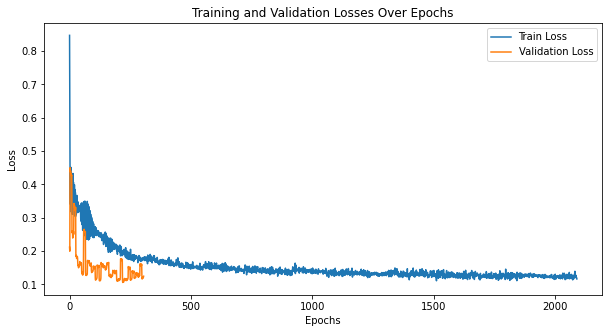

In [ ]:
train_losses = model.train_losses
val_losses = model.val_losses

# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.show()

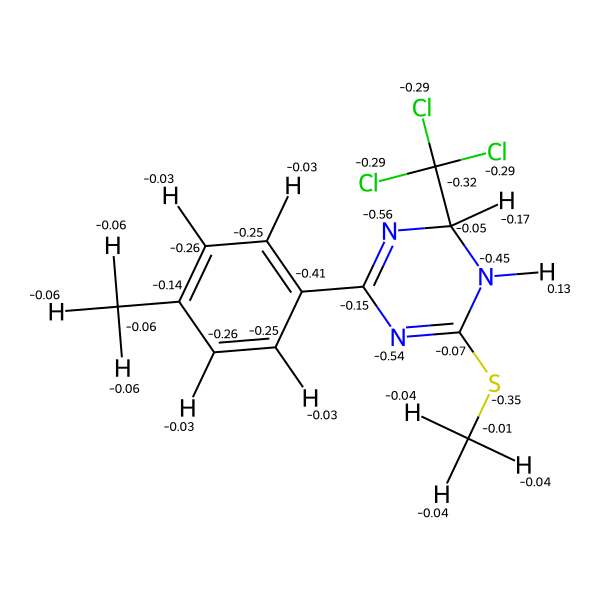

In [ ]:
def draw_molecule(smiles, predictions):
    mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
    predictions_rounded = np.round(predictions, 2)

    for atom, pred in zip(mol.GetAtoms(), predictions_rounded):
        atom.SetProp('atomNote', str(pred))

    img = Chem.Draw.MolToImage(mol, size=(600, 600), kekulize=True)
    img.show()


df_results = model.df_results

smiles = df_results.iloc[0]['smiles']
predictions = df_results.iloc[0]['predictions']
draw_molecule(smiles, predictions)
